### SPLC'25

Two goals:
- launching some graphs about the coreutils data
- computing correlations between #locs, #runtime options and binary size of small programs extracted out of coreutils, see https://github.com/coreutils/coreutils

### Libs

In [36]:
import os 

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.ticker import ScalarFormatter
import matplotlib.patheffects as pe

# git clone tree-sitter c https://github.com/tree-sitter/tree-sitter-c
from treelib import Node, Tree
from tree_sitter import Language, Parser

Language.build_library('../../build/my-languages.so', ['../../tree-sitter-c'])
C_LANGUAGE = Language('../../build/my-languages.so', 'c')
parser = Parser()
parser.set_language(C_LANGUAGE)

from scipy.stats import spearmanr

### Importing data runtime

In [37]:
df = pd.read_csv("../measures/final2.csv")
df = df.dropna()
df

,program,options,size,size KiB,LoC
0,[,24,297584,290,653
1,arch,2,194864,190,287
2,b2sum,13,370488,361,1243
3,base32,5,241264,235,940
4,base64,5,240248,234,940
...,...,...,...,...,...
103,vdir,60,825696,806,4095
104,wc,8,292216,285,775
105,who,18,295144,288,621
106,whoami,2,194944,190,59


### Get usage of the different functions in the linux kernel

#### List all bash files in the Linux kernel

In [38]:
linux_dir = '../../linux/'
# after cloning https://github.com/torvalds/linux 

all_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(linux_dir)) for f in fn]

all_bash_files = [f for f in all_files if f[-3:]=='.sh']

# number of bash files
len(all_bash_files)

756

#### List all words in the bash files

In [39]:
words = []

for bash_f in all_bash_files:
    file = open(bash_f, 'r')
    read_data = file.read()
    per_word = read_data.split()
    words.extend(per_word)

len(words)

506345

In [40]:
all_bash_files

['../../linux/Documentation/sound/cards/multisound.sh',
 '../../linux/Documentation/admin-guide/aoe/status.sh',
 '../../linux/Documentation/admin-guide/aoe/udev-install.sh',
 '../../linux/Documentation/admin-guide/aoe/autoload.sh',
 '../../linux/Documentation/features/list-arch.sh',
 '../../linux/Documentation/features/scripts/features-refresh.sh',
 '../../linux/Documentation/s390/config3270.sh',
 '../../linux/Documentation/arm64/kasan-offsets.sh',
 '../../linux/Documentation/sphinx/parallel-wrapper.sh',
 '../../linux/arch/x86/boot/genimage.sh',
 '../../linux/arch/x86/boot/install.sh',
 '../../linux/arch/x86/kernel/cpu/mkcapflags.sh',
 '../../linux/arch/x86/entry/vdso/checkundef.sh',
 '../../linux/arch/x86/um/vdso/checkundef.sh',
 '../../linux/arch/riscv/boot/install.sh',
 '../../linux/arch/riscv/kernel/compat_vdso/gen_compat_vdso_offsets.sh',
 '../../linux/arch/riscv/kernel/vdso/gen_vdso_offsets.sh',
 '../../linux/arch/powerpc/boot/install.sh',
 '../../linux/arch/powerpc/kernel/prom_i

#### Initiate a dictionary with the count of coreutils functions

In [41]:
name = df['program']

countw = dict()

for n in name:
    countw[n] = 0

for w in words:
    for n in name:
        if n in w:
            countw[n]+=1

countw

{'[': 7908,
 'arch': 444,
 'b2sum': 0,
 'base32': 0,
 'base64': 1,
 'basename': 82,
 'basenc': 0,
 'cat': 1104,
 'chcon': 0,
 'chgrp': 0,
 'chmod': 11,
 'chown': 7,
 'chroot': 0,
 'cksum': 60,
 'comm': 615,
 'cp': 1683,
 'csplit': 0,
 'cut': 272,
 'date': 336,
 'dd': 10171,
 'df': 44,
 'dir': 2382,
 'dircolors': 0,
 'dirname': 179,
 'du': 2216,
 'echo': 6033,
 'env': 65,
 'expand': 22,
 'expr': 66,
 'factor': 7,
 'false': 144,
 'fmt': 6,
 'fold': 5,
 'groups': 72,
 'head': 396,
 'hostid': 3,
 'hostname': 4,
 'install': 470,
 'id': 6951,
 'join': 192,
 'kill': 221,
 'link': 5578,
 'ln': 133,
 'logname': 0,
 'ls': 2595,
 'md5sum': 27,
 'mkdir': 93,
 'mkfifo': 0,
 'mknod': 7,
 'mktemp': 258,
 'mv': 62,
 'nice': 6,
 'nl': 1645,
 'nohup': 3,
 'nproc': 9,
 'numfmt': 0,
 'od': 3437,
 'paste': 1,
 'pathchk': 0,
 'pinky': 0,
 'pr': 7460,
 'printenv': 0,
 'printf': 803,
 'ptx': 1,
 'pwd': 26,
 'readlink': 14,
 'realpath': 24,
 'rm': 1631,
 'rmdir': 29,
 'runcon': 0,
 'seq': 265,
 'sha1sum': 5,
 

#### Join the data to the current dataframe

In [42]:
cn = [countw[n] for n in name]

usage = []
# 2 = high usage, ofetn used
# 1 = medium, not so often but still
# 0 = few utilisations of the coreutils function

for i in range(len(cn)):
    if cn[i] > 1000:
        usage.append(2)
    else:
        if cn[i] > 50:
            usage.append(1)
        else:
            usage.append(0)

df['usage'] = usage

#### Compile-time options

In [43]:
dep_graph = {'[' : ['test.c'],
'arch' : ['uname-arch.c', 'uname.c'],
'b2sum' : ['digest.c'],
'base32' : ['basenc.c'],
'base64' : ['basenc.c'],
'basename' : ['basename.c'],
'basenc' : ['basenc.c'],
'cat' : ['cat.c'],
'chcon' : ['chcon.c'],
'chgrp' : ['chgrp.c'],
'chmod' : ['chmod.c'],
'chown' : ['chown.c'],
'chroot' : ['chroot.c'],
'cksum' : ['cksum.c','digest.c'],
'comm' : ['comm.c'],
'cp' : ['cp.c'],
'csplit' : ['csplit.c'],
'cut' : ['cut.c'],
'date' : ['date.c'],
'dd' : ['dd.c'],
'df' : ['df.c'],
'dir' : ['ls-dir.c', 'ls.c'],
'dircolors' : [ 'dircolors.c'],
'dirname' : [ 'dirname.c'],
'du' : [ 'du.c'],
'echo' : [ 'echo.c'],
'env' : [ 'env.c'],
'expand' : [ 'expand.c'],
'expr' : [ 'expr.c'],
'factor' : [ 'factor.c'],
'false' : ['false.c', 'true.c'],
'fmt' : [ 'fmt.c'],
'fold' : [ 'fold.c'],
'groups' : [ 'groups.c'],
'head' : [ 'head.c'],
'hostid' : [ 'hostid.c'],
'hostname' : [ 'hostname.c'],
'id' : [ 'id.c'],
'install' : [ 'install.c'],
'join' : [ 'join.c'],
'kill' : [ 'kill.c'],
'link' : ['force-link.c', 'link.c'],
'ln' : [ 'ln.c'],
'logname' : [ 'logname.c'],
'ls' : ['ls-ls.c', 'ls.c'],
'md5sum' : [ 'digest.c'],
'mkdir' : [ 'mkdir.c'],
'mkfifo' : [ 'mkfifo.c'],
'mknod' : [ 'mknod.c'],
'mktemp' : [ 'mktemp.c'],
'mv' : [ 'mv.c'],
'nice' : [ 'nice.c'],
'nl' : [ 'nl.c'],
'nohup' : [ 'nohup.c'],
'nproc' : [ 'nproc.c'],
'numfmt' : [ 'numfmt.c'],
'od' : [ 'od.c'],
'paste' : [ 'paste.c'],
'pathchk' : [ 'pathchk.c'],
'pinky' : [ 'pinky.c'],
'pr' : [ 'pr.c'],
'printenv' : [ 'printenv.c'],
'printf' : [ 'printf.c'],
'ptx' : [ 'ptx.c'],
'pwd' : [ 'pwd.c'],
'readlink' : [ 'readlink.c'],
'realpath' : [ 'realpath.c'],
'rm' : [ 'rm.c'],
'rmdir' : [ 'rmdir.c'],
'runcon' : [ 'runcon.c'],
'seq' : [ 'seq.c'],
'sha1sum' : [ 'digest.c'],
'sha224sum' : [ 'digest.c'],
'sha256sum' : [ 'digest.c'],
'sha384sum' : [ 'digest.c'],
'sha512sum' : [ 'digest.c'],
'shred' : [ 'shred.c'],
'shuf' : [ 'shuf.c'],
'sleep' : [ 'sleep.c'],
'sort' : [ 'sort.c'],
'split' : [ 'split.c'],
'stat' : [ 'stat.c'],
'stdbuf' : [ 'stdbuf.c'],
'stty' : [ 'stty.c'],
'sum' : ['sum.c', 'digest.c'],
'sync' : [ 'sync.c'],
'tac' : [ 'tac.c'],
'tail' : [ 'tail.c'],
'tee' : [ 'tee.c'],
'test' : [ 'test.c'],
'timeout' : [ 'timeout.c'],
'touch' : [ 'touch.c'],
'tr' : [ 'tr.c'],
'true' : [ 'true.c'],
'truncate' : [ 'truncate.c'],
'tsort' : [ 'tsort.c'],
'tty' : [ 'tty.c'],
'uname' : ['uname-uname.c','uname.c'],
'unexpand' : [ 'unexpand.c'],
'uniq' : [ 'uniq.c'],
'unlink' : [ 'unlink.c'],
'uptime' : [ 'uptime.c'],
'users' : [ 'users.c'],
'vdir' : ['ls-vdir.c','ls.c'],
'wc' : [ 'wc.c'],
'who' : [ 'who.c'],
'whoami' : [ 'whoami.c'],
'yes' : [ 'yes.c']}


# we cloned coreutils in the parent directory 
all_c_files =[]
for dep in dep_graph:
    all_c_files.extend(dep_graph[dep])

core_dir='../../coreutils/src/'

# sanity check to test if all files are present
assert(np.sum([1 for ar in all_c_files if os.path.exists(core_dir+ar)])==len(all_c_files))

def get_code(source, node):
    ### input : a node of the ast
    ### output : get the "code" of the node of the ast, 
    ### i.e. the string content of the related part in the code

    code = source[node.start_byte:node.end_byte].decode('utf8')
    code = code.replace('\n', '').replace('\t','')
    return code
    
nb_comp = dict()
opt_comp = dict()

for dg in dep_graph:
    nb_comp[dg] = 0
    opt_comp[dg] = []

for dg in dep_graph:
    for c_path in dep_graph[dg]:
        
        comps = []

        s=""
        with open(core_dir+c_path, "r") as f:
            s+=f.read()+"\n"

        #print('#if' in s)
        #print('#ifndef' in s)

        source = bytes(s, "utf8")
        ast = parser.parse(source)
        root_node = ast.root_node

        for child in root_node.children:
            if child.type in ["preproc_if", "preproc_def", "preproc_ifdef"]:
                for n in child.children:
                    if n.type == 'binary_expression':
                        for nc in n.children:
                            if nc.type in ['unary_expression', 'identifier']:
                                new_comp = get_code(source, nc).replace('!',
                                                                       '').replace('defined', 
                                                                                   '').replace(' ', 
                                                                                               '')
                                if new_comp not in comps:
                                    comps.append(new_comp)
                    if n.type in ['unary_expression', 'identifier']:
                        new_comp = get_code(source, n).replace('!','').replace('defined', '').replace(' ', '')
                        if new_comp not in comps:
                            comps.append(new_comp)
        opt_comp[dg].extend(comps)

for oc in opt_comp:
    nb_comp[oc] = len(opt_comp[oc])
    
df['comp'] = [nb_comp[oc] for oc in df['program']]

In [44]:
df.to_csv("../measures/final4.csv")

## Bubble Chart

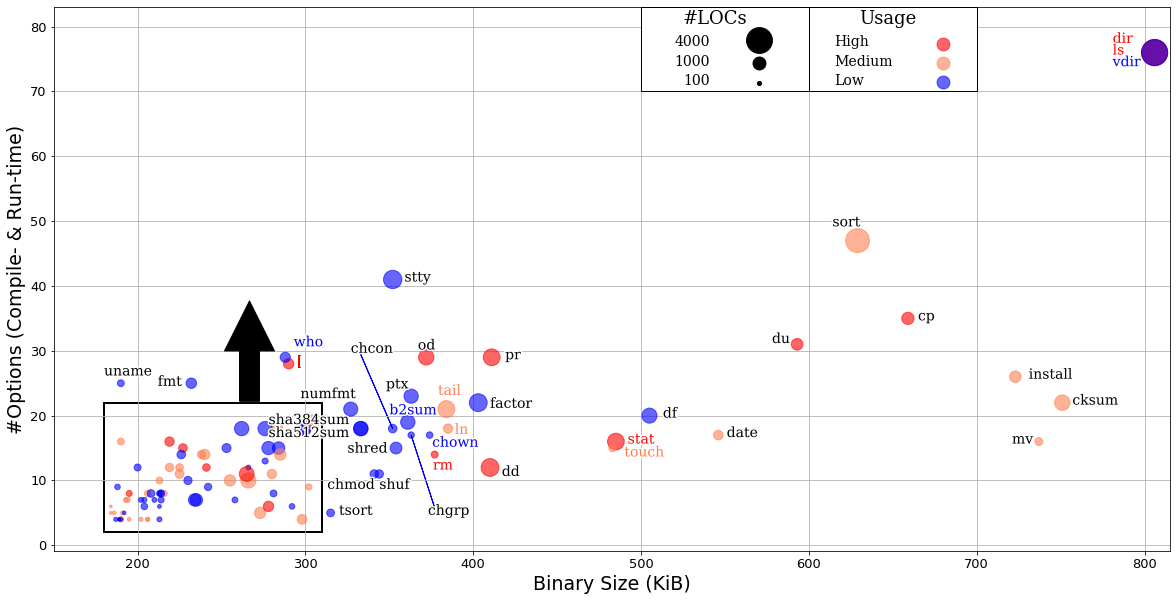

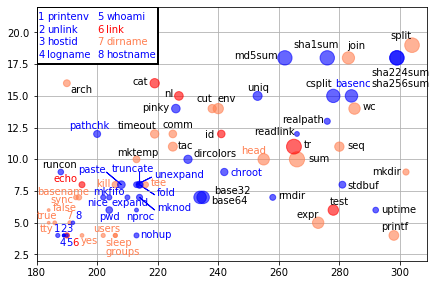

In [236]:
fig, ax = plt.subplots(1,figsize=(20,10))

loc = np.array(df['LoC']/6, int)
binn = np.array(df['size KiB'], dtype=int)
runt = np.array(df['options']+df['comp'], dtype=float)
name = df['program']
usage = df['usage']

alpha = 0.6
color = ['blue', 'coral', 'red']

plt.scatter(binn, 
            runt, 
            s = loc, 
            alpha = alpha, 
            color = [color[us] for us in usage], 
            zorder = 3)

positions = dict({
'[' : (0, 0),
'arch' : (0.5, -0.7),
'b2sum' : (-16, 1.5),
'base32' : (3, 0.4),
'base64' : (3, -0.4),
'basenc' : (-6, 0.8),
'basename' : (-13.5, 0.3),
'cat' : (-8, 0),
'chcon' : (-30, 12),
'chgrp' : (5, -12),
'chmod' : (-33, -2),
'chown' : (-3.5, -1.5),
'chroot' : (1.5, -0.2),
'cksum' : (1, 0),
'comm' : (-4, 0.6),
'cp' : (1, 0),
'csplit' : (-10, 0.8),
'cut' : (-6, 0.6),
'date' : (0, 0),
'dd' : (2, -1),
'df' : (3, 0),
'dir': (-30, 1.8),
'dircolors' : (1, 0.3),
'dirname' : (-2, 0.4),
'du' : (-20, 0.5),
'echo' : (-10, 0.3),
'env' : (-1, 0.6),
'expand' : (-6, -0.6),
'expr' : (-8, 0.5),
'factor' : (2, -0.5),
'false' : (0.5, 0),
'fmt' : (-25, -0.1),
'fold' : (5, -0.8),
'groups' : (-4, -1.4),
'head' : (-8, 0.5),
'hostid' : (0, 0.4),
'hostname' : (0, 0.4),
'id' : (-6, -0.2),
'install' : (3, 0),
'join' : (-1, 0.8),
'kill' : (-7, -0.1),
'link' : (1, -0.7),
'ln' : (-1, -0.5),
'logname' : (-2, -0.7),
'ls' : (-30, 0),
'md5sum': (-17.5, 0),
'mkdir' : (-12, -0.1),
'mkfifo' : (-4, 0.3),
'mknod' : (5, -1),
'mktemp' : (-7, 0.4),
'mv' : (-21, 0),
'nice' : (-8, -0.6),
'nl' : (-5.5, 0),
'nohup' : (0.5, -0.1),
'nproc' : (-4, -0.7),
'numfmt' : (-35, 2),
'od' : (-10, 1.5),
'paste' : (-15, 1),
'pathchk' : (-10, 0.5),
'pinky' : (-12, -0.1),
'pr' : (3, 0),
'printenv' : (-2, 0.4),
'printf' : (-5, 0.5),
'ptx' : (-20, 1.5),
'pwd' : (-4, -0.7),
'readlink' : (-15, 0),
'realpath' : (-15.5, 0),
'rm' : (-6, -2),
'rmdir' : (1, -0.05),
'runcon' : (-7, 0.4),
'seq' : (2, -0.1),
'sha1sum' : (-12, 0.9),
'sha224sum' : (-9, -1.3),
'sha256sum' : (-9, -2.2),
'sha384sum' : (-60, 1),
'sha512sum' : (-60, -1),
'shred' : (-34, -0.4),
'shuf' : (-5, -2),
'sleep' : (-4, -0.7),
'sort' : (-20, 2.5),
'split' : (-8, 0.6),
'stat' : (2, 0),
'stdbuf' : (1, -0.2),
'stty' : (2, 0),
'sum' : (3, -0.1),
'sync' : (-10, -0.3),
'tac' : (1, -0.1),
'tail' : (-10, 2.5),
'tee' : (1, 0),
'test' : (-2, 0.5),
'timeout' : (-13, 0.5),
'touch' : (2, -1),
'tr' : (2.5, 0),
'true' : (-4.5, 0.4),
'truncate' : (-10, 1.1),
'tsort' : (0, 0),
'tty' : (-5.5, -0.6),
'uname' : (-15, 1.5),
'unexpand' : (5, 0.6),
'uniq' : (-4, 0.5),
'unlink' : (-2, 0.4),
'uptime' : (1, -0.1),
'users' : (-4, 0.4),
'vdir' : (-30, -1.8), 
'wc' : (2, 0),
'who' : (0, 2),
'whoami' : (-1, -0.7),
'yes' : (-1, -0.6)})

xmin = 180
xmax = 310
ymin = 2
ymax = 22

font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14,
        }


name_to_color = ['ls', 'vdir', 'dir', 'pathchk', 'echo', 'basename', 'paste', 
                 'kill', 'expand', 'mkfifo', 'fold', 'mknod', 'truncate', 'nohup', 'groups',
                 'sleep', 'users', 'true', 'false', 'printenv', 'yes',
                'printenv', 'unlink', 'hostid', 'logname', 'whoami', 'link', 'hostname',
                'stat', 'touch', 'who', '[', 'chown', 'ln', 'rm', 'b2sum', 'tail', 'basenc',
                'head', 'chroot', 'sync', 'tty', 'dirname', 'tee', 'unexpand', 'nice', 'pwd',
                'nproc']
# add color for names whose points are overlapped

# link chgrp to its point
ax.arrow(352+positions['chcon'][0]+10, 
         18+positions['chcon'][1], 
         -positions['chcon'][0]-10, 
         -positions['chcon'][1],
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

ax.arrow(363+positions['chgrp'][0]+10, 
         17+positions['chgrp'][1], 
         -positions['chgrp'][0]-10, 
         -positions['chgrp'][1],
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

for i in range(len(binn)):
    if (binn[i] < xmin or binn[i]>xmax) or runt[i] > ymax:
        if name[i] in name_to_color:
            plt.text(binn[i]+5+positions[name[i]][0], 
                     runt[i]-0.3+positions[name[i]][1], 
                     name[i], 
                     path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                     zorder=3,
                     fontdict= {'family': 'serif', 
                                'color': color[usage[i]], 
                                'weight': 'normal', 
                                'size': 14})
        else:
            plt.text(binn[i]+5+positions[name[i]][0], 
                     runt[i]-0.3+positions[name[i]][1], 
                     name[i], 
                     zorder=3,
                     path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                     fontdict=font)

ax.add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, linewidth=2, edgecolor='black', facecolor='none'))

ax.add_patch(FancyArrowPatch((xmin+2*(xmax-xmin)/3, ymax-0.1), 
                             (xmin+2*(xmax-xmin)/3, 38),
                              mutation_scale=100, 
                             zorder = 3,
                             fc = 'black'))

# legend - size of bubbles
ax.add_patch(Rectangle(
        (500, 70),
        100,
        83-70,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

plt.scatter(570, 71.3, s = 100/6, color = "black", zorder = 4)
plt.text(525, 71,"100", fontdict = font)
plt.scatter(570, 74.4, s = 1000/6, color = "black", zorder = 4)
plt.text(520, 74,"1000", fontdict = font)
plt.scatter(570, 78, s = 4000/6, color = "black", zorder = 4)
plt.text(520, 77,"4000", fontdict = font)
plt.text(525, 80.4,"#LOCs", fontdict = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        })

# legend - colors of bubbles
ax.add_patch(Rectangle(
        (600, 70),
        100,
        83-70,
        edgecolor = 'black',
        facecolor = 'white',
        fill=True,
        zorder=3
 ))

plt.scatter(680, 71.4, s = 1000/6, alpha= alpha, color = color[0], zorder = 4)
plt.text(615, 71, "Low", fontdict = font)
plt.scatter(680, 74.4, s = 1000/6, alpha= alpha, color = color[1], zorder = 4)
plt.text(615, 74,"Medium", fontdict = font)
plt.scatter(680, 77.4, s = 1000/6, alpha= alpha, color = color[2], zorder = 4)
plt.text(615, 77, "High", fontdict = font)
plt.text(630, 
         80.4, 
         "Usage", 
         fontdict = {'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 18,
        })

plt.grid()
plt.xticks(size=13)
plt.yticks(size=13)
plt.ylabel("#Options (Compile- & Run-time)", fontsize = 19)
plt.xlabel("Binary Size (KiB)", fontsize = 19)
#plt.xscale("log")
plt.ylim(ymin=-0.85, ymax=83)
plt.xlim(xmin=150, xmax=815)
plt.savefig("../figures/bubble_fig.png", dpi =300)
plt.show()

fig, ax = plt.subplots(1, figsize=(7, 14/3))

plt.scatter(binn, runt, s=loc, alpha= alpha, color= [color[us] for us in usage], zorder=3)

# replace some names with number and put them in legend

ax.add_patch(Rectangle((180, 17.5),
                       40,
                       ymax-17.5, 
                       linewidth=2, 
                       edgecolor='black', 
                       facecolor = 'white',
                       fill=True,
                       zorder=3))

ax.arrow(214+positions['mknod'][0], 
         7+positions['mknod'][1], 
         -positions['mknod'][0], 
         -positions['mknod'][1],
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

ax.arrow(214+positions['fold'][0], 
         8+positions['fold'][1], 
         -positions['fold'][0], 
         -positions['fold'][1],
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

ax.arrow(208+positions['paste'][0]+10, 
         8+positions['paste'][1], 
         -positions['paste'][0]-10, 
         -positions['paste'][1],
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

ax.arrow(213+positions['unexpand'][0], 
         8+positions['unexpand'][1], 
         -positions['unexpand'][0], 
         -positions['unexpand'][1],
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

ax.arrow(214+positions['truncate'][0]+10, 
         8+positions['truncate'][1]-0.1, 
         -positions['truncate'][0]-10, 
         -positions['truncate'][1]+0.1,
         head_width=0.01, 
         head_length=0.01, 
         fc='blue', 
         ec='blue')

replace_with_numbers = ['printenv', 'unlink', 'hostid', 'logname', 'whoami', 'link', 'dirname', 'hostname']

for i in range(len(replace_with_numbers)):
    n = replace_with_numbers[i]
    if i <4 :
        plt.text(180.5, 
                 14+(8-i-1)*(ymax-14)/8, 
                 str(i+1), 
                 zorder=3,
                 fontdict= {'color': color[usage[[k for k in name].index(n)]]})
        plt.text(183.5, 
             14+(8-i-1)*(ymax-14)/8, 
             n, 
             zorder=3,
             fontdict= {'color': color[usage[[k for k in name].index(n)]]})
    else:
        plt.text(200, 
                 14+(8-i%4-1)*(ymax-14)/8, 
                 str(i+1), 
                 zorder=3,
                 fontdict= {'color': color[usage[[k for k in name].index(n)]]})
        plt.text(203, 
             14+(8-i%4-1)*(ymax-14)/8, 
             n, 
             zorder=3,
             fontdict= {'color': color[usage[[k for k in name].index(n)]]})

for i in range(len(binn)):
    if binn[i] > xmin and binn[i]<xmax and runt[i] <ymax:
        if binn[i] > xmin and binn[i]<xmax and runt[i] <ymax:
            n = name[i]
            if name[i] in replace_with_numbers:
                n = str(replace_with_numbers.index(n)+1)
            if name[i] in name_to_color:
                plt.text(binn[i]+0.7+positions[name[i]][0], 
                         runt[i]-0.1+positions[name[i]][1], 
                         n, 
                         #path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                         zorder=3,
                         fontdict= {'color': color[usage[i]]})
            else:
                plt.text(binn[i]+0.7+positions[name[i]][0], 
                         runt[i]-0.1+positions[name[i]][1], 
                         n, 
                         zorder=3,
                         #path_effects=[pe.withStroke(linewidth=3, foreground="white")],
                        )

plt.grid()
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax-1)
plt.savefig("../figures/bubble_fig_min.png", dpi = 300)
plt.show()
runt = np.array(df['options'], dtype=float)

### compile-time

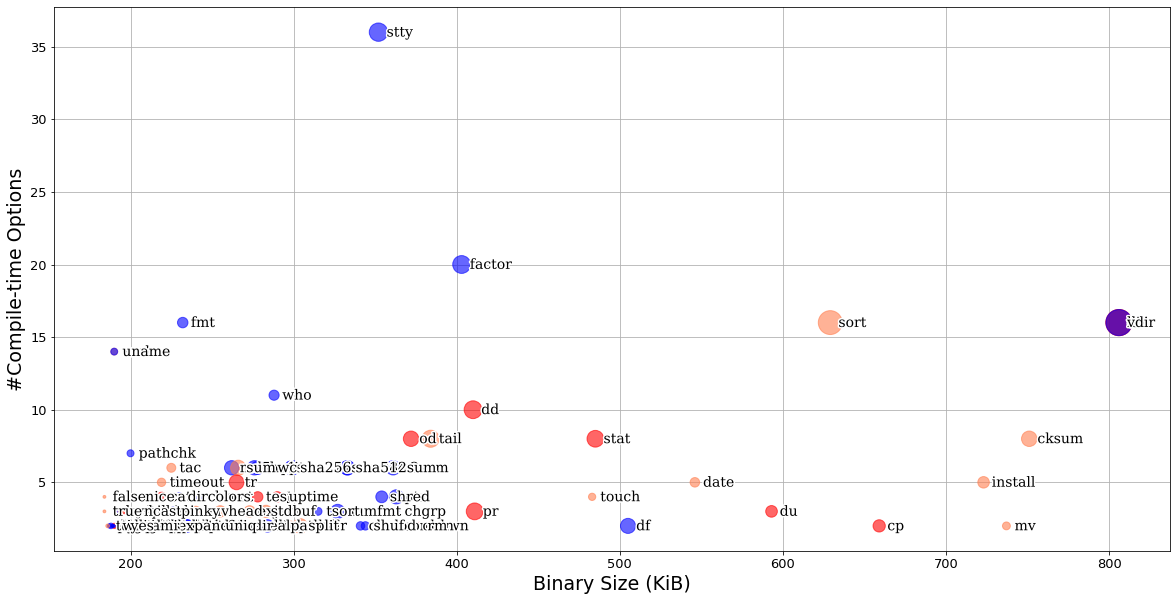

In [11]:
fig, ax = plt.subplots(1,figsize=(20,10))

comp = np.array(df['comp'], dtype=float)

plt.scatter(binn, 
            comp, 
            s = loc, 
            alpha = alpha, 
            color = [color[us] for us in usage], 
            zorder = 3)

font = {
    'family': 'serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14,
        }

for i in range(len(binn)):
    plt.text(binn[i]+5, 
             comp[i]-0.3, 
             name[i],
             zorder=3,
             path_effects=[pe.withStroke(linewidth=3, foreground="white")],
             fontdict=font)

plt.grid()
plt.xticks(size=13)
plt.yticks(size=13)
plt.ylabel("#Compile-time Options", fontsize = 19)
plt.xlabel("Binary Size (KiB)", fontsize = 19)
#plt.xscale("log")
#plt.ylim(ymin=-0.85, ymax=40)
#plt.xlim(xmin=150, xmax=815)
plt.savefig("../figures/bubble_fig_comp.png", dpi =300)
plt.show()

### Importing data runtime

In [29]:
df_evo = pd.read_csv("../measures/evo_loc.csv")
df_evo = df_evo.dropna()
df_evo

,version,arch,dd,expr,factor,false,groups,hostid,hostname,link,...,nohup,printf,sleep,true,tsort,unlink,uptime,users,whoami,yes
0,v4.5.1,0,910,625,150,0,0,54,85,62,...,0,450,209,43,392,61,188,124,71,78
1,v4.5.2,0,908,625,150,0,0,54,85,62,...,0,455,127,43,392,61,188,124,71,78
2,v4.5.3,0,911,625,150,0,0,54,85,62,...,0,455,127,43,392,61,188,124,71,78
3,v4.5.4,0,908,611,150,0,0,54,85,62,...,0,455,127,43,392,61,188,124,71,78
4,v4.5.5,0,908,611,150,0,0,54,85,62,...,0,455,127,43,392,61,188,124,71,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,v8.30,284,1847,870,1928,52,103,56,86,171,...,157,558,109,50,381,60,200,110,65,90
81,v8.31,284,1841,870,1928,52,103,50,80,163,...,151,558,102,50,375,54,194,104,59,84
82,v8.32,284,1885,870,1928,52,103,50,80,163,...,151,558,102,50,375,54,195,104,59,88
83,v9.0,284,1869,777,1900,52,103,50,81,163,...,151,558,102,50,376,54,195,104,59,88


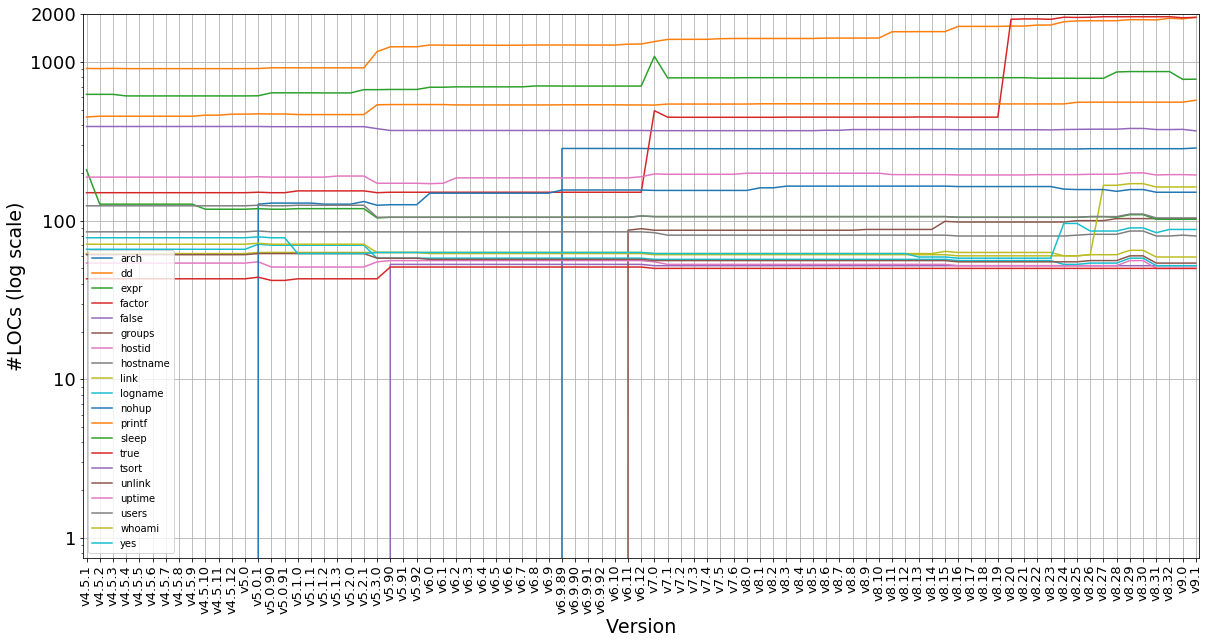

In [30]:
fig, ax = plt.subplots(1,figsize=(20,10))

for col in df_evo.columns[1:]:
    tab = [int(k) for k in df_evo[col] if k!='-']
    version = [i for i in range(df_evo.shape[0]) if df_evo[col][i]!='-']
    if len(tab)>0:
        plt.plot(version, tab, zorder=3, label = col)

plt.grid()
plt.legend()
plt.xticks(size=13)

ax.set_xticks([k for k in range(df_evo.shape[0])])
ax.set_xticklabels(df_evo['version'], size =13, rotation = 90)

plt.yscale("log")

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks([1, 10, 100, 1000, 2000])
ax.set_yticklabels([1, 10, 100, 1000, 2000], size =18, rotation = 0)


plt.ylabel("#LOCs (log scale)", fontsize = 19)
plt.xlabel("Version", fontsize = 19)

ax.set_ylim(ymin=0.75, ymax=2000)
ax.set_xlim(xmin=-0.25, xmax=df_evo.shape[0]-0.75)
plt.savefig("../figures/evo_loc2.png", dpi =300)
plt.show()

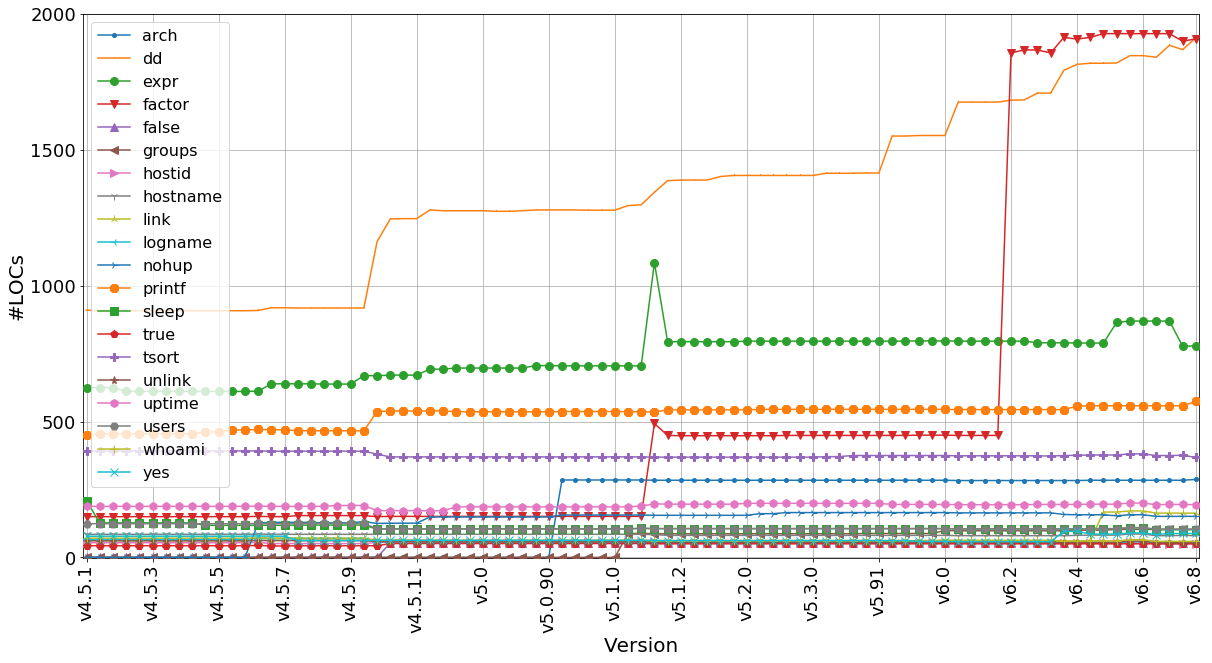

In [35]:
fig, ax = plt.subplots(1,figsize=(20,10))

mStyles = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x",
           "X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]

for i in range(len(df_evo.columns[1:])):
    col = df_evo.columns[1:][i]
    tab = [int(k) for k in df_evo[col] if k!='-']
    version = [i for i in range(df_evo.shape[0]) if df_evo[col][i]!='-']
    if len(tab)>0:
        plt.plot(version, tab, marker = mStyles[i], markersize = 8, zorder=3, label = col)

plt.grid()
plt.legend(prop={'size': 16})
plt.xticks(size=13)

ax.set_xticks([k for k in range(df_evo.shape[0]) if k%5==0 or k == df_evo.shape[0]-1])
ax.set_xticklabels([df_evo['version'][v] for v in range(len(df_evo['version'])) if v%2==0], 
                   size =18, rotation = 90)

#plt.yscale("log")

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks([0, 500, 1000, 1500, 2000])
ax.set_yticklabels([0, 500, 1000, 1500, 2000], size =18, rotation = 0)


plt.ylabel("#LOCs", fontsize = 20)
plt.xlabel("Version", fontsize = 20)

ax.set_ylim(ymin=-1, ymax=2000)
ax.set_xlim(xmin=-0.25, xmax=df_evo.shape[0]-0.75)
plt.savefig("../figures/evo_loc1.png", dpi =300, bbox_inches='tight')
plt.show()

### Correlations

#### Binary size x runtime 

In [15]:
#Pearson
np.corrcoef(binn, runt)[0,1]

0.7844414149443201

In [16]:
# Spearman
spearmanr(binn, runt)

SpearmanrResult(correlation=0.6981897167506182, pvalue=4.521998599944622e-17)

#### Binary size x comptime 

In [24]:
#Pearson
np.corrcoef(binn, comp)[0,1]

0.3754736728065425

In [25]:
# Spearman
spearmanr(binn, comp)

SpearmanrResult(correlation=0.38246209328842584, pvalue=4.4106997357715236e-05)

#### LOC x runtime 

In [17]:
#Pearson
np.corrcoef(loc, runt)[0,1]

0.7804380365272894

In [18]:
# Spearman
spearmanr(loc, runt)

SpearmanrResult(correlation=0.6264015912370525, pvalue=4.148838439044523e-13)

#### LOC x comptime 

In [26]:
#Pearson
np.corrcoef(loc, comp)[0,1]

0.6454767825752703

In [27]:
# Spearman
spearmanr(loc, comp)

SpearmanrResult(correlation=0.6106915829875289, pvalue=2.255005513086012e-12)

#### run x comp

In [28]:
#Pearson
np.corrcoef(runt, comp)[0,1]

0.3453327622071661

In [29]:
# Spearman
spearmanr(runt, comp)

SpearmanrResult(correlation=0.23362631986624627, pvalue=0.014956101814650494)

#### Binary size x LOC

In [19]:
#Pearson
np.corrcoef(binn, loc)[0,1]

0.7200030034001716

In [20]:
# Spearman
spearmanr(binn, runt)

SpearmanrResult(correlation=0.6981897167506182, pvalue=4.521998599944622e-17)